# k-Fold Cross-Validation Experiments with Outliers and High Leverage Samples

## k-Fold Cross Validation
When selecting models or model hyperparameters, we wish to ideally select based on which model performs best on all possible values of the data. However, usually, we are only given training data, which do not cover the full support of our data distribution. k-Fold Cross-Validation (k-fold CV) is a technique for estimating the error we expect on data that go beyond the training data (which we'll call test set) but still come from the same distribution of the training set.

However, because of the way k-fold CV works (which is you shuffle then split into k-groups), it's possible this becomes problematic for estimating the test performance (or error) when we have rare extreme values of input $X$ (high leverage datapoints) that result in extreme values of response $Y$ (outliers).

## Violation of the iid Assumption
k-fold CV splits the training data in a way that violates the iid (independent, indentically-distributed) assumption when we estimate the error, e.g. MSE. Why? Because it splits the data into k-folds without replacement. And putting high leverage/outlier points in one validation fold/group essentially removes the probability it gets selected for the other folds. This could potentially limit its applicability as an estimator of test set error.

## Synthetic Dataset
To test our speculation, we experiment on a synthetic dataset of the form 

$Y = \beta_0 + \beta_1 X_1^2 + \beta_2 X_2^2 ... + \beta_p X_p^2 + \epsilon$

where $\epsilon$ is an independent error term taken from a normal distribution $N(0, 1)$. Why square the predictors instead of just keep it linear? Making it a simple linear sum will make the problem trivial for a linear regression model, which is the model we use in these experiments. We want to fit a linear model on this quadratic function.

To add high-leverage / outlier points, we randomly select a proportion of samples for each predictor independent of other predictors. Then we multiply those values of $X_j$ by some multiplier. The responses $Y_j$ are simply computed using the quadratic model defined above.

We generated 1 million datapoints, 10,000 of these were randomly selected for the train set, while the rest were used for the test set. 

## Experiment Setup
We first checked the reliability of k-fold CV on this dataset. We chose $k=100$. We shuffled the train data, then we split into 100 folds/groups. Then we apply k-fold CV, getting a total of 100 MSEs. We then compute the mean of these MSEs and that becomes the k-fold MSE estimate. But we are not concerned with this particular estimate. We are concerned with the reliability of k-fold CV as a method, so we run 100 trials of 100-fold CV. Each trial we get the mean MSE, each of which is an estimate of the test MSE, 

$\hat{\text{MSE}} = \text{mean}({\text{MSE}_{CV}}) \approx \text{MSE}_{test}$.

## Results

We then analyzed the mean and standard deviation of these estimates and found that the standard deviation of the estimate is low and $\text{mean}(\hat{\text{MSE}}) \pm \text{std}(\hat{\text{MSE}})$ does not cover the ground truth test MSE. The ground truth test MSE is computed by fitting on the entire train set and testing on the test set.

We find that $\hat{\text{MSE}}$ has low variance as an estimator, so running different trials of k-fold CV will more or less yield the same result. So while we will rarely have a case where we will more closely match the $\text{MSE}_{test}$, the consistency of the results is an advantage of k-fold CV in this case.

We then speculated an alternative method that does not suffer the iid violation of k-fold CV. The approach is we simply do a simple validation split, but do it 100 times which we'll call "fold" for consistency. Each time, we shuffle the data and split into 99% training and 1% validation. This no longer violates the iid assumption because each fold does not rob the other folds of the possibility of picking particular datapoints. We then get the mean of the 100 MSEs. Then again, we are concerned with the reliability of the approach, so we ran 100 trials, with each trial computing the mean of 100 MSEs. We then analyzed the distribution of MSEs and found that the $\text{mean}(\hat{\text{MSE}}) \pm \text{std}(\hat{\text{MSE}})$ now captures the ground truth test MSE.

However, the new approach has an increased variance such that running any of this 100-"fold" validation to estimate $\hat{\text{MSE}}$ will more likely yield much more varied results.

We tested on the more realistic 10-fold and 5-fold CV and we get similar results.

In the absence of outliers, the two approaches still more or less have the same $\text{mean}(\hat{\text{MSE}})$, but the standard deviation (relative to the mean) of the second approach is much lower when there are no outliers vs when there are outliers. One possible take-away is k-fold CV is more "robust" to the presence of outliers, having a narrow standard deviation (over many trials) which speaks about its stability, and hence reliability.

The second approach is more prone to high variance of predictions, which may not be desirable, despite supposedly being more aligned with the iid assumption when estimating a statistic.

## Some Questions
We find that it seems k-fold CV has low variance, even if it's far from the true test MSE. Doing simple validation many times and averaging the results yield similar results as k-fold CV but with higher variance. What's the explanation for these?

We're not sure how general these results are or if there are flaws in how we set up these experiments. 

## Experiment Details

We define our function as a linear model of $X_j^2$ predictors with some random noise. In this toy example, we sample the ground truth coefficients from a normal distribution, and we sample $X$ from a normal distribution as well. A certain proportion of each predictor $X_j$ is independently chosen and multiplied by a multiplier to serve as high leverage data points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# define a ground truth generative function
def gen_func(n=1000000, n_predictors=5, p_leverage=0.001, mult_leverage=10, seed=42):
    np.random.seed(seed)
    coeffs = np.random.normal(0, 1, size=n_predictors)
    X = np.random.normal(0, 1, size=(n, n_predictors))

    # for each x_i, we randomly select p_leverage% and multiply by mult_leverage
    inds = np.random.choice(range(X.shape[0]), (int(X.shape[1]), int(X.shape[0]*p_leverage)))
    X[inds] = X[inds] * mult_leverage

    Y = 10 + X**2 @ coeffs + np.random.normal(0, 1) # make it squared
    return X, Y, coeffs

We generate 1 million datapoints from our generator. 10,000 are randomly selected to be the training data (from which we will derive the validation sets as well)

In [2]:
def gen_train_test(N, N_train, **kwargs):

    X, Y, coeffs = gen_func(**kwargs)
    inds = np.arange(N)
    np.random.seed(42)
    np.random.shuffle(inds)
    inds_train = inds[:N_train]
    inds_test = inds[N_train:]

    X_train = X[inds_train]
    Y_train = Y[inds_train]

    X_test = X[inds_test]
    Y_test = Y[inds_test]

    print("Coefficients:                ", coeffs)
    print("len(X_train), len(X_test):   ", len(X_train), len(X_test))
    print("len (Y_train), len(Y_test):  ", len(Y_train), len(Y_test))

    return X_train, X_test, Y_train, Y_test

In [3]:
N = 1000000
N_train = 10000
kwargs = dict(n=N, n_predictors=5, p_leverage=0.0001, mult_leverage=10, seed=42)
X_train, X_test, Y_train, Y_test = gen_train_test(N, N_train, **kwargs)

Coefficients:                 [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
len(X_train), len(X_test):    10000 990000
len (Y_train), len(Y_test):   10000 990000


We visualize below each $X_j$ vs $Y$ in our training data

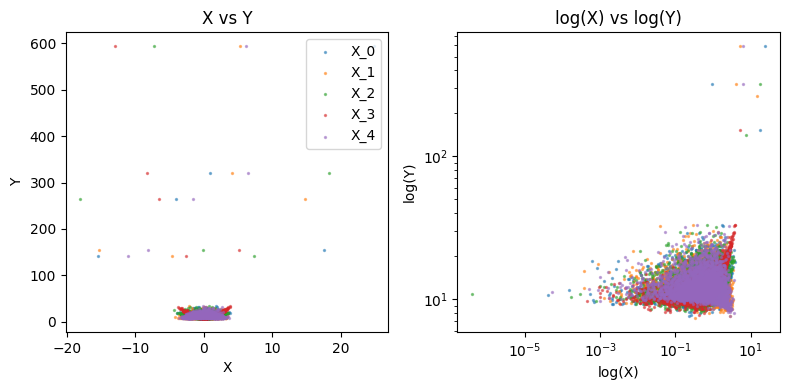

In [4]:
def plot_data(X_train, Y_train):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for i in range(X_train.shape[1]):
        axs[0].scatter(X_train[:, i], Y_train, s=2, alpha=0.5, label=f"X_{i}")
        axs[0].set_ylabel("Y")
        axs[0].set_xlabel("X")
        axs[0].set_title("X vs Y")

        axs[1].scatter(X_train[:, i], Y_train, s=2, alpha=0.5, label=f"X_{i}")
        axs[1].loglog()
        axs[1].set_ylabel("log(Y)")
        axs[1].set_xlabel("log(X)")
        axs[1].set_title("log(X) vs log(Y)")    
        axs[0].legend()
    plt.tight_layout()

plot_data(X_train, Y_train)    

### 100-fold CV

We run k-fold CV over many trials using linear regression. Each k-fold CV trial yields an estimate $\hat{\text{MSE}} = \text{mean}({\text{MSE}_{CV}}) \approx \text{MSE}_{test}$. Running many trials, we can get a mean and standard deviation of the $\hat{\text{MSE}}$ estimates, which we compare with the ground truth $MSE_{test}$

The chart below shows the highly skewed ${\text{MSE}_{CV}}$ values for one trial of k-fold CV. This is due to the presence of high-leverage/outlier points in the training data. But we are not concerned with the distribution of errors in one trial of k-fold CV. We are concerned with the distribution of the estimates $\hat{\text{MSE}}$

In [5]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def run_kfold_trials(k_folds, trials, X_train, Y_train):

    k_folds_idx = np.array(np.split(np.arange(len(X_train)), k_folds))
    mse_means = []
    mse_stds = []

    np.random.seed(42)
    for trial in range(trials):

        inds = np.arange(len(X_train))
        np.random.shuffle(inds)
        X_train_shuffled = X_train[inds]
        Y_train_shuffled = Y_train[inds]


        mse_list = []
        coeffs_list = []

        for k in range(k_folds):

            k_folds_idx_retain = np.delete(np.arange(k_folds), k)
            sample_idx_train = k_folds_idx[k_folds_idx_retain].flatten()
            sample_idx_valid = k_folds_idx[k].flatten()

            X_fold_train = X_train_shuffled[sample_idx_train]
            X_fold_valid = X_train_shuffled[sample_idx_valid]

            Y_fold_train = Y_train_shuffled[sample_idx_train]
            Y_fold_valid = Y_train_shuffled[sample_idx_valid]

            # Create linear regression object
            regr = linear_model.LinearRegression()

            # Train the model using the training sets
            regr.fit(X_fold_train, Y_fold_train)

            # Make predictions using the testing set
            y_pred = regr.predict(X_fold_valid)

            coeffs_list += [regr.coef_]
            mse_list += [mean_squared_error(Y_fold_valid, y_pred)]       

        coeffs_list = np.array(coeffs_list)
        mse_list = np.array(mse_list)    

        # compute the mean MSE from cross validation
        mse_mean = np.mean(mse_list)

        # compute the standard deviation
        mse_std = np.std(mse_list)    

        mse_means += [mse_mean]
        mse_stds += [mse_std]

        if trial == 0:
            fig, axs = plt.subplots(1, 3, figsize=(12, 3))        
            axs[0].hist(mse_list, cumulative=False)

            axs[1].boxplot(mse_list)
            axs[2].boxplot(mse_list, showfliers=False)

            axs[0].set_title("MSE histogram for 1 CV trial")        
            axs[1].set_title("MSEs with outliers for 1 CV trial")
            axs[2].set_title("MSEs without outliers for 1 CV trial")
            plt.tight_layout()
            plt.show()      
    
    return mse_means, mse_stds

We define 100 k-folds and 100 trials (100-fold each).

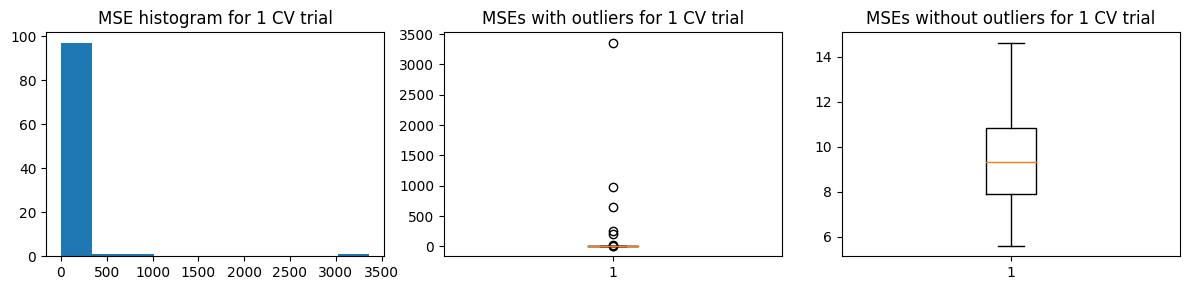

In [6]:
# do standard k-fold cross validation
k_folds = 100
trials = 100
mse_means, mse_stds = run_kfold_trials(k_folds, trials, X_train, Y_train)

We show below the distribution of $\hat{\text{MSE}}$ from 100 trials

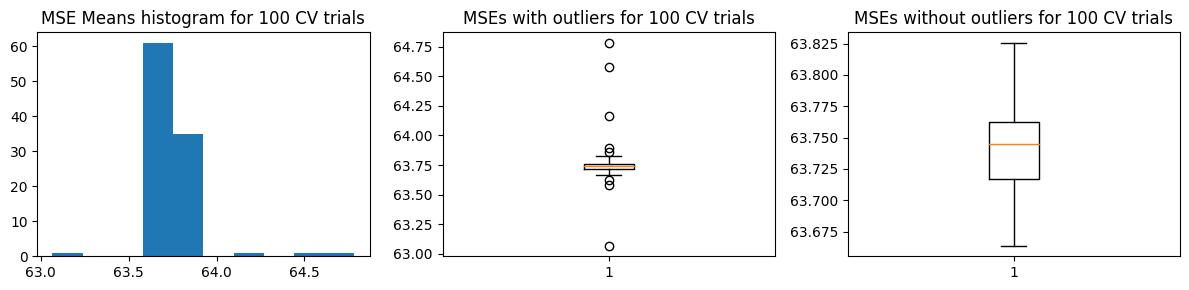

In [7]:
def plot_mse_dists(mse_means):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))        
    axs[0].hist(mse_means, cumulative=False)

    axs[1].boxplot(mse_means)
    axs[2].boxplot(mse_means, showfliers=False)

    axs[0].set_title(f"MSE Means histogram for {trials} CV trials")        
    axs[1].set_title(f"MSEs with outliers for {trials} CV trials")
    axs[2].set_title(f"MSEs without outliers for {trials} CV trials")
    plt.tight_layout()
    plt.show()    

plot_mse_dists(mse_means)       

We computed the ground truth $\text{MSE}_{test}$ as well as the mean and standard deviation of $\hat{\text{MSE}}$. We find that $\text{mean}(\hat{\text{MSE}}) \pm \text{std}(\hat{\text{MSE}})$ does not cover $\text{MSE}_{test}$. However, the estimated $\hat{\text{MSE}}$ has low variance so it speaks about the consistency of the results when using k-fold CV for this problem.

In [8]:
def compare_w_test_mse(mse_means, X_train, Y_train, X_test, Y_test):
    # compute the mean MSE from cross validation
    mse_mean = np.mean(mse_means)

    # compute the standard deviation
    mse_std = np.std(mse_means)

    # compute the true MSE from the test set when trained on the entire train set
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    mse_gt = mean_squared_error(Y_test, y_pred)

    print("Mean MSE         ", mse_mean)
    print("Std Dev MSE      ", mse_std)
    print("Ground truth MSE ", mse_gt)

compare_w_test_mse(mse_means, X_train, Y_train, X_test, Y_test)    

Mean MSE          63.75660471426123
Std Dev MSE       0.15955756270713287
Ground truth MSE  53.04536320061062


The problem with k-fold CV is if you have rare outliers/high leverage points, it's possible they get concentrated in one validation fold/group. And this causes the distribution of errors to be highly skewed. Once these points are chosen in one fold, they're no longer available for the other folds. Thus each k-fold becomes dependent on others, and no longer iid. This violates the assumption of the Central Limit Theorem and prevents us from computing say the standard error properly (which requires iid samples).

How might we go around this? What if instead of regular k-fold, we run a simple train-valid set split but run it 100 times, randomizing each time. With this, we make each validation MSE an iid sample because even if we got datapoints $X_j, Y_j$ the other "folds" of train-valid splits will still have the chance to select them.

Again, we show below the distribution of $\text{MSE}_{CV}$ for a single trial (100 validation runs). But we are concerned with the reliability of this estimate, so we run 100 trials.

In [9]:
def run_kfold2_trials(k_folds, trials, X_train, Y_train):
    mse_means = []
    mse_stds = []

    for trial in range(trials):

        mse_list = []
        coeffs_list = []

        np.random.choice(42)
        for k in range(k_folds):

            sample_idx = np.arange(len(X_train))
            np.random.shuffle(sample_idx)
            train_idx = sample_idx[len(X_train)//k_folds:]
            valid_idx = sample_idx[:len(X_train)//k_folds]

            X_fold_train = X_train[train_idx]
            X_fold_valid = X_train[valid_idx]

            Y_fold_train = Y_train[train_idx]
            Y_fold_valid = Y_train[valid_idx]

            # Create linear regression object
            regr = linear_model.LinearRegression()

            # Train the model using the training sets
            regr.fit(X_fold_train, Y_fold_train)

            # Make predictions using the testing set
            y_pred = regr.predict(X_fold_valid)

            coeffs_list += [regr.coef_]
            mse_list += [mean_squared_error(Y_fold_valid, y_pred)]       

        coeffs_list = np.array(coeffs_list)
        mse_list = np.array(mse_list)    

        # compute the mean MSE from cross validation
        mse_mean = np.mean(mse_list)

        # compute the standard deviation
        mse_std = np.std(mse_list)    

        mse_means += [mse_mean]
        mse_stds += [mse_std]

        if trial == 0:
            fig, axs = plt.subplots(1, 3, figsize=(12, 3))        
            axs[0].hist(mse_list, cumulative=False)

            axs[1].boxplot(mse_list)
            axs[2].boxplot(mse_list, showfliers=False)

            axs[0].set_title("MSE histogram for 1 CV trial")        
            axs[1].set_title("MSEs with outliers for 1 CV trial")
            axs[2].set_title("MSEs without outliers for 1 CV trial")
            plt.tight_layout()
            plt.show()  

    return mse_means, mse_stds     

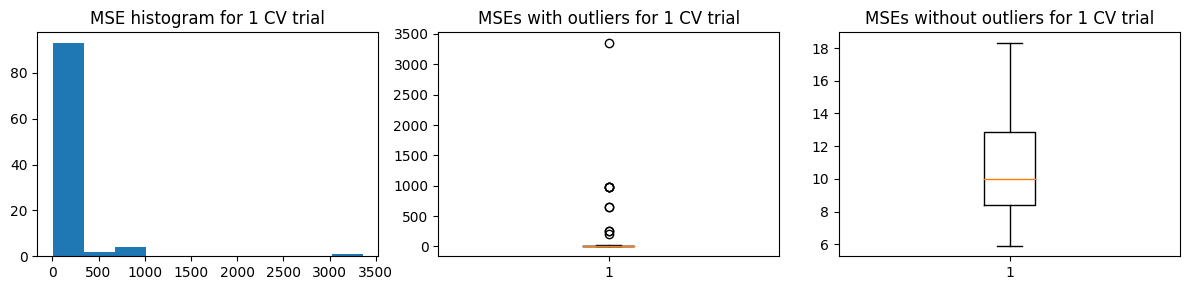

In [10]:
# do standard k-fold cross validation
k_folds = 100
trials = 100
mse_means, mse_stds = run_kfold2_trials(k_folds, trials, X_train, Y_train)

We show below the distribution of $\hat{\text{MSE}}$ from 100 trials

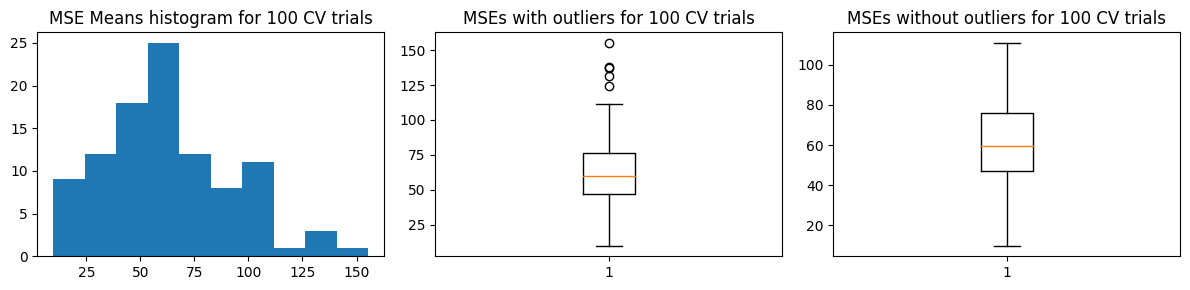

In [11]:
plot_mse_dists(mse_means)

We find that $\text{mean}(\hat{\text{MSE}}) \pm \text{std}(\hat{\text{MSE}})$ covers $\text{MSE}_{test}$. But the increased variance means we expect different results each run of 100-"fold" validation.

Is this approach more reliable than conventional k-fold? How general is this result?

In [12]:
compare_w_test_mse(mse_means, X_train, Y_train, X_test, Y_test)

Mean MSE          62.99516870328772
Std Dev MSE       30.44480934715585
Ground truth MSE  53.04536320061062


### 10-fold CV

The problem with our experiments above is that our training set is small yet we're using 100-fold validation. This will make the validation runs correlated since chances are they will share much of the dataset with each other. So now, we experiment on the more realistic 10-fold validation. We still run over 100 trials.

We show below the results of a sample MSE histogram for one trial of 10-fold CV (top charts) and we show the distribution of values of $\hat{\text{MSE}}$ over 100 trials of 10-fold CV. We find that we get more or less the same result as the 100-fold CV.

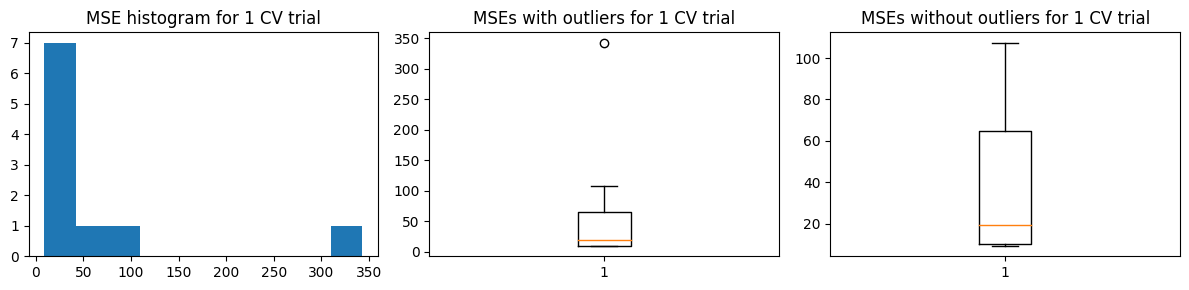

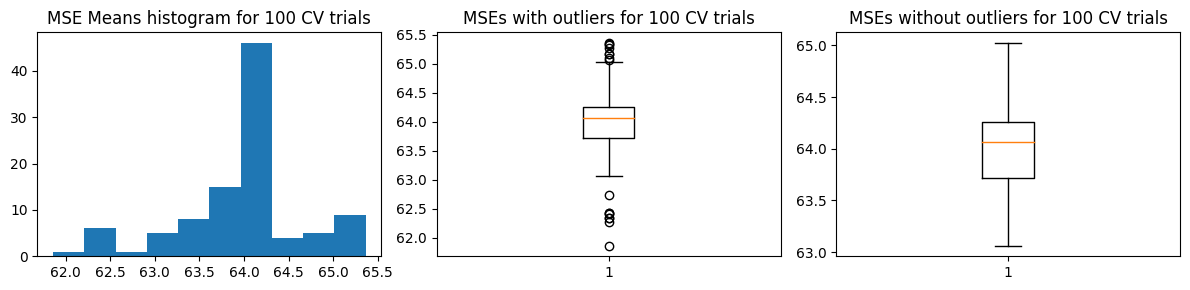

Mean MSE          63.974719087827445
Std Dev MSE       0.6883531568069371
Ground truth MSE  53.04536320061062


In [13]:
# do standard k-fold cross validation
k_folds = 10
trials = 100
mse_means, mse_stds = run_kfold_trials(k_folds, trials, X_train, Y_train)
plot_mse_dists(mse_means)
compare_w_test_mse(mse_means, X_train, Y_train, X_test, Y_test)

We show the results for the alternative approach. We also get more or less the same results, with some increase in the estimated $\hat{\text{MSE}}$

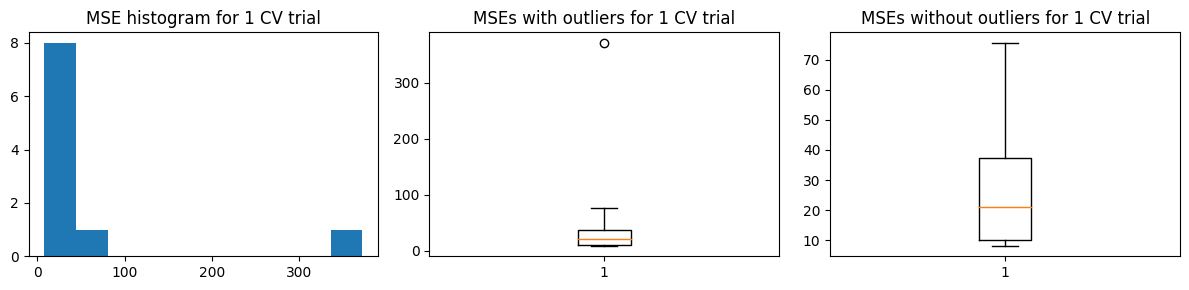

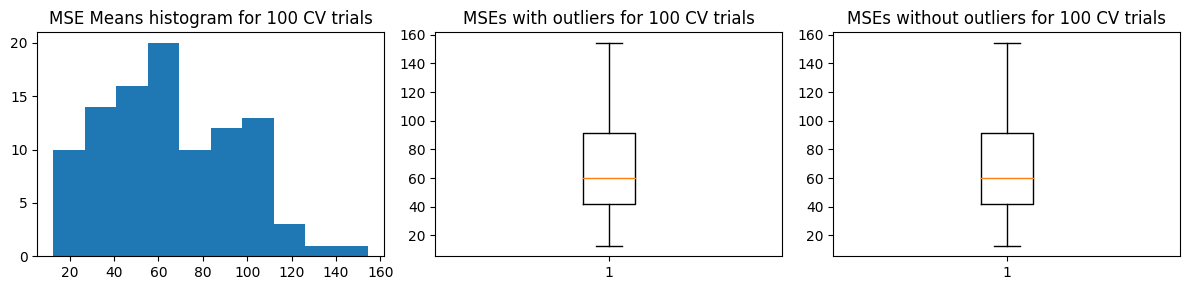

Mean MSE          65.70430794964277
Std Dev MSE       30.53296639484907
Ground truth MSE  53.04536320061062


In [14]:
# do standard k-fold cross validation
k_folds = 10
trials = 100
mse_means, mse_stds = run_kfold2_trials(k_folds, trials, X_train, Y_train)
plot_mse_dists(mse_means)
compare_w_test_mse(mse_means, X_train, Y_train, X_test, Y_test)

### 5-fold CV

There's no marked changes when we use 5-fold CV. We show below the results of k-fold CV.

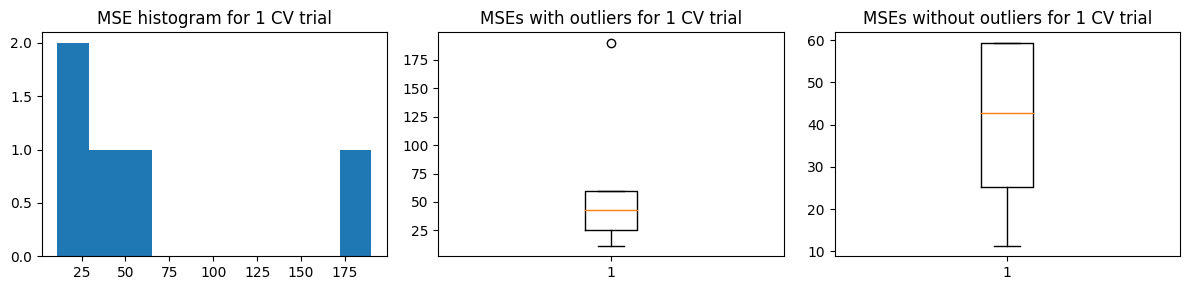

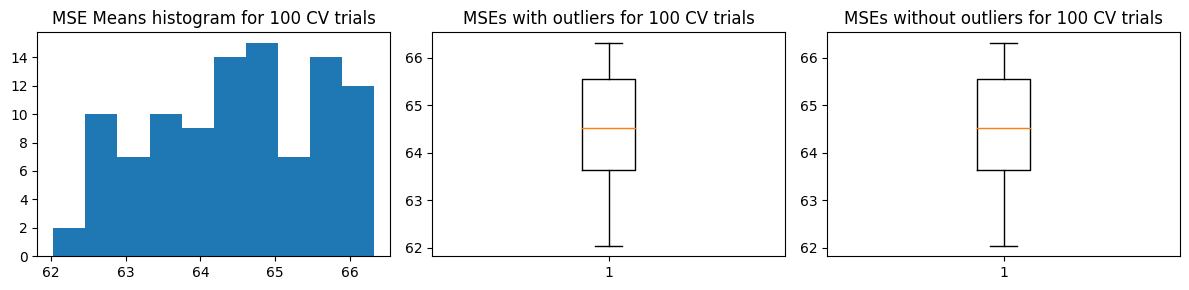

Mean MSE          64.47303996932304
Std Dev MSE       1.1310935713605763
Ground truth MSE  53.04536320061062


In [15]:
# do standard k-fold cross validation
k_folds = 5
trials = 100
mse_means, mse_stds = run_kfold_trials(k_folds, trials, X_train, Y_train)
plot_mse_dists(mse_means)
compare_w_test_mse(mse_means, X_train, Y_train, X_test, Y_test)

We show below the results of the alternative approach.

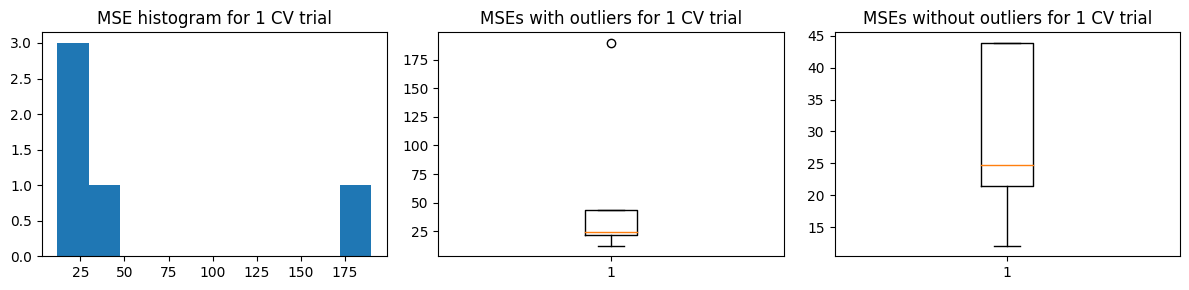

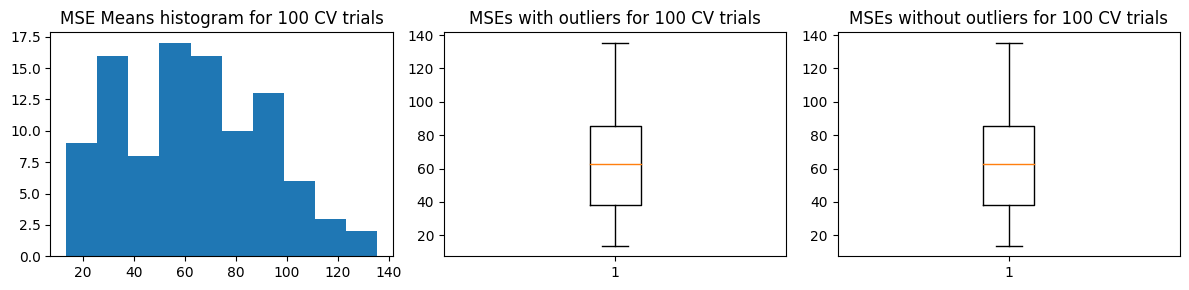

Mean MSE          63.535512108530845
Std Dev MSE       28.412100685752357
Ground truth MSE  53.04536320061062


In [16]:
# do standard k-fold cross validation
k_folds = 5
trials = 100
mse_means, mse_stds = run_kfold2_trials(k_folds, trials, X_train, Y_train)
plot_mse_dists(mse_means)
compare_w_test_mse(mse_means, X_train, Y_train, X_test, Y_test)

### What if no outliers?

Coefficients:                 [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
len(X_train), len(X_test):    10000 990000
len (Y_train), len(Y_test):   10000 990000


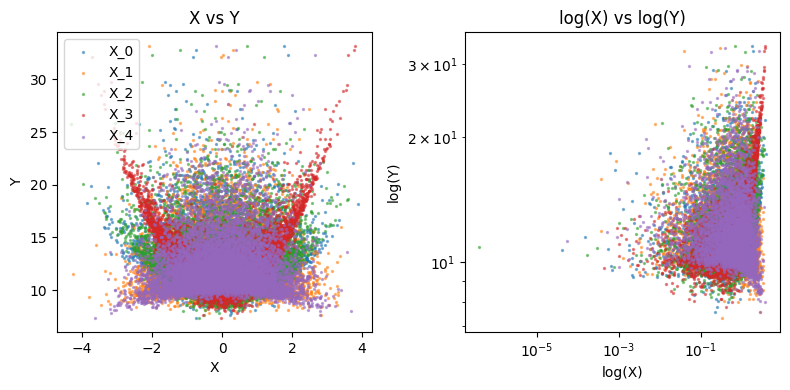

In [17]:
N = 1000000
N_train = 10000
kwargs = dict(n=N, n_predictors=5, p_leverage=0.000, mult_leverage=10, seed=42)
X_train, X_test, Y_train, Y_test = gen_train_test(N, N_train, **kwargs)

plot_data(X_train, Y_train)

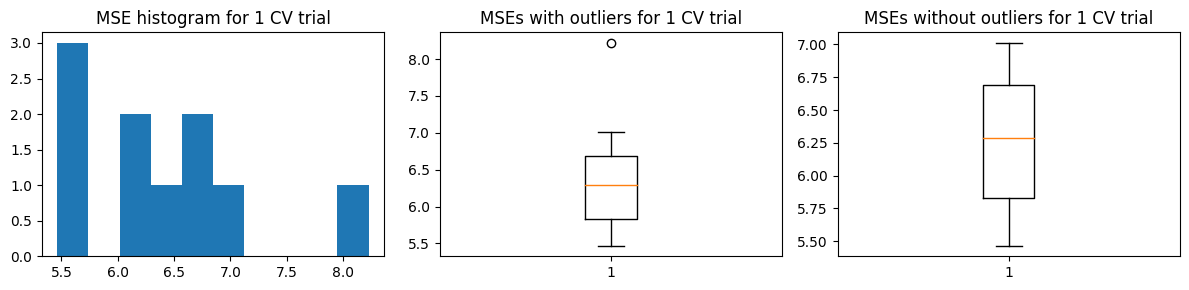

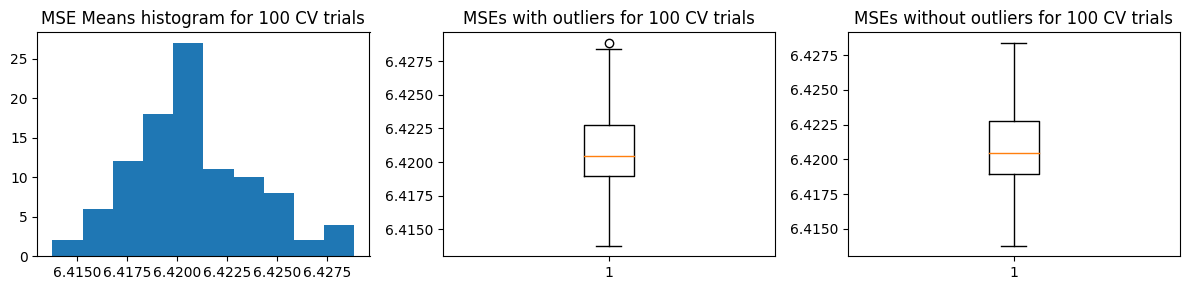

Mean MSE          6.420870371804342
Std Dev MSE       0.00300694628307649
Ground truth MSE  6.108880543132803


In [18]:
# do standard k-fold cross validation
k_folds = 10
trials = 100
mse_means, mse_stds = run_kfold_trials(k_folds, trials, X_train, Y_train)
plot_mse_dists(mse_means)
compare_w_test_mse(mse_means, X_train, Y_train, X_test, Y_test)

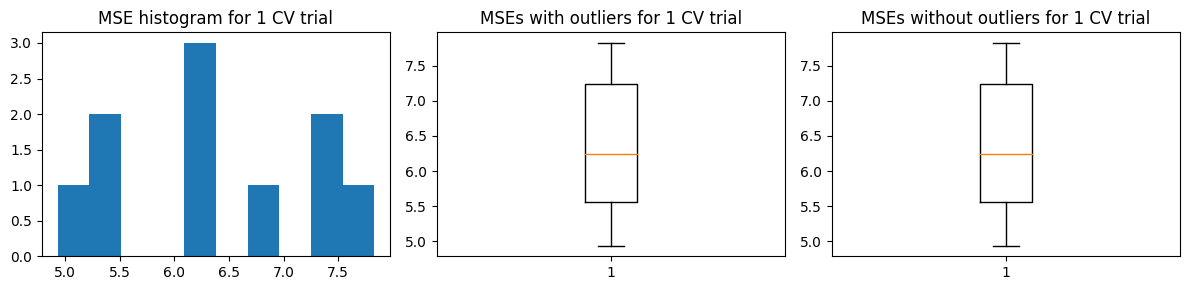

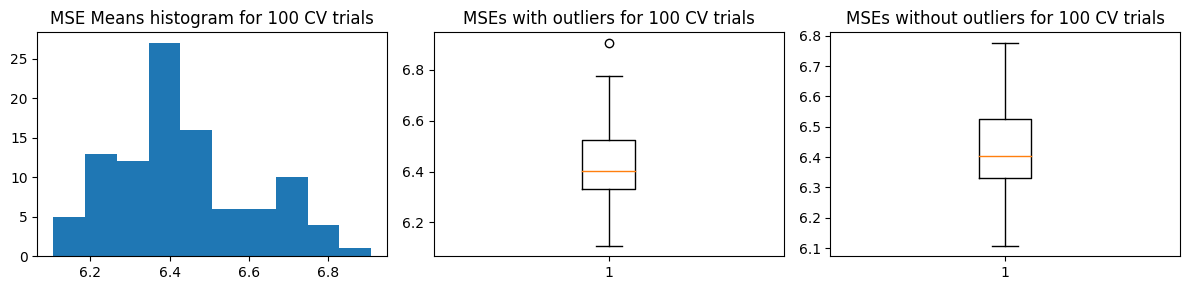

Mean MSE          6.43568995376575
Std Dev MSE       0.17346395707747458
Ground truth MSE  6.108880543132803


In [19]:
# do standard k-fold cross validation
k_folds = 10
trials = 100
mse_means, mse_stds = run_kfold2_trials(k_folds, trials, X_train, Y_train)
plot_mse_dists(mse_means)
compare_w_test_mse(mse_means, X_train, Y_train, X_test, Y_test)

### Use in Hyperparameter Tuning